## Exploratory Analysis

This section showcases insights that we can derive from the 2023-2025 Kpop Music Award Show wins. This notebook utilizes an sql extension to showcase queries in a SQL-format, utilizing the database we created in the previous notebook.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os

sys.path.append(os.path.abspath("../scripts"))

%config SqlMagic.style = '_DEPRECATED_DEFAULT'
%load_ext sql

In [2]:
%sql sqlite:///../data/sql/clean.db

In [3]:
%%sql
SELECT name FROM sqlite_master WHERE type='table';

 * sqlite:///../data/sql/clean.db
Done.


name
all_awards
artist_metadata


The result above outlines the two tables we have available for queries: `all_awards` and `artist_metadata`. The schema for the tables are defined as follows:

- `all_awards`: Contains award show placement data from 2023-2025
    - **show**: which show the placement comes from
    - **date**: the date when the show's episode aired
    - **placement**: how well an artist placed in voting
    - **artist**: the name of the artist 
    - **song**: the name of the track
    - **total**: total score based on the music show's criteria
    - **source_table**: name of the table the information comes from

- `artist_metadata`: Contains additional data to broaden the analysis; defines whether an artist is a group/soloist, the gender of the member(s), and the debut of the group.
    - **artist**: the name of the artist
    - **Group_solo**: determines whether an artist is a group or a soloist
    - **Member Gender**: determines the gender of the group: male, female, coed
    - **Debut Date**: when a group debuted 

With this understanding of the table's schemas, we can create some queries to gain insight on Korean Music Award Shows.

In [4]:
%%sql
WITH top3_placements AS (
    SELECT * FROM all_awards
    WHERE placement <= 3
    )

SELECT 
    COUNT(a.date) as original_shape,
    COUNT(t3.date) as top3_shape
FROM all_awards a
LEFT JOIN top3_placements t3 ON
    a.artist = t3.artist AND a.song = t3.song AND a.date = t3.date

 * sqlite:///../data/sql/clean.db
Done.


original_shape,top3_shape
1845,1658


In [5]:
%%sql
WITH joined_placements AS (SELECT 
    a.*,
    m.Group_Solo,
    m.'Member Gender',
    m.'Debut Date'
FROM all_awards a
JOIN artist_metadata m ON
a.artist = m.artist
ORDER BY a.date, a.placement
)

SELECT * 
FROM joined_placements
LIMIT 5
;

 * sqlite:///../data/sql/clean.db
Done.


show,date,placement,artist,song,total,source_table,Group_Solo,Member Gender,Debut Date
Music Bank,2023-01-06 00:00:00,1,ATEEZ,Halazia,8793,2023_music_bank,group,male,2018-10-24 00:00:00
Music Bank,2023-01-06 00:00:00,2,NewJeans,Ditto,4556,manual_awards.xlsx,group,female,2022-07-22 00:00:00
Show! Music Core,2023-01-07 00:00:00,1,NewJeans,Ditto,5843,2023_show_music_core,group,female,2022-07-22 00:00:00
Show! Music Core,2023-01-07 00:00:00,2,NCT DREAM,Candy,5157,manual_awards.xlsx,group,male,2016-08-24 00:00:00
Show! Music Core,2023-01-07 00:00:00,3,ATEEZ,Halazia,3915,manual_awards.xlsx,group,male,2018-10-24 00:00:00


In [6]:
%%sql
WITH joined_placements AS (SELECT 
    a.*,
    m.Group_Solo,
    m.'Member Gender',
    m.'Debut Date'
FROM all_awards a
JOIN artist_metadata m ON
a.artist = m.artist
ORDER BY a.date, a.placement
)

SELECT artist, song, COUNT(*) as total_wins 
FROM joined_placements
WHERE placement = 1
GROUP BY artist, song 
ORDER BY total_wins DESC
LIMIT 5
;

 * sqlite:///../data/sql/clean.db
Done.


artist,song,total_wins
Jung Kook,Seven (feat. Latto),13
i-dle,Queencard,13
ILLIT,Magnetic,12
IVE,REBEL HEART,11
G-Dragon,TOO BAD (feat. Anderson Paak),10


## Top 5 Songs with the Most Wins per Year

In [7]:
%%sql
WITH joined_placements AS (
    SELECT 
        a.*,
        m.Group_Solo,
        m.'Member Gender',
        m.'Debut Date'
    FROM all_awards a
    JOIN artist_metadata m ON
    a.artist = m.artist
    ORDER BY a.date, a.placement
), 
yearly_win_counts AS (
    SELECT 
        DISTINCT STRFTIME('%Y', date) as year,
        artist, 
        song, 
        COUNT(*) as total_wins
    FROM joined_placements
    WHERE placement = 1
    GROUP BY year, artist, song
    ORDER BY total_wins DESC
),
ranked_wins AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (PARTITION BY year ORDER BY total_wins DESC) as rank
    FROM yearly_win_counts
)

SELECT 
    year,
    artist,
    song,
    total_wins
FROM ranked_wins
WHERE rank <= 5
ORDER BY year, rank
;

 * sqlite:///../data/sql/clean.db
Done.


year,artist,song,total_wins
2023,Jung Kook,Seven (feat. Latto),13
2023,i-dle,Queencard,13
2023,IVE,I Am,9
2023,Jisoo,Flower,9
2023,BSS,Fighting,8
2024,ILLIT,Magnetic,12
2024,LE SSERAFIM,EASY,9
2024,IU,Love wins all,8
2024,ROSÉ,APT (with Bruno Mars),8
2024,aespa,Supernova,8


In [8]:
%%sql ranked_wins <<
WITH joined_placements AS (
    SELECT 
        a.*,
        m.Group_Solo,
        m."Member Gender",
        m."Debut Date"
    FROM all_awards a
    JOIN artist_metadata m ON a.artist = m.artist
),
yearly_song_appearances AS (
    SELECT 
        STRFTIME('%Y', date) AS year,
        artist, 
        song, 
        COUNT(*) AS total_appearances
    FROM joined_placements
    GROUP BY year, artist, song
),
yearly_win_counts AS (
    SELECT 
        STRFTIME('%Y', date) AS year,
        artist, 
        song, 
        COUNT(*) AS total_wins
    FROM joined_placements
    WHERE placement = 1
    GROUP BY year, artist, song
),
ranked_wins AS (
    SELECT 
        w.year,
        w.artist,
        w.song,
        w.total_wins,
        COALESCE(a.total_appearances, 0) AS total_appearances,
        ROW_NUMBER() OVER (PARTITION BY w.year ORDER BY w.total_wins DESC) AS rank
    FROM yearly_win_counts w
    LEFT JOIN yearly_song_appearances a 
        ON w.year = a.year AND w.artist = a.artist AND w.song = a.song
)

SELECT 
    year,
    artist,
    song,
    total_wins,
    total_appearances,
    ROUND(total_wins* 100/ CAST(total_appearances as DECIMAL), 2) as win_appear_percentage,
    rank
FROM ranked_wins
--WHERE rank <= 5
ORDER BY year, rank;

 * sqlite:///../data/sql/clean.db
Done.
Returning data to local variable ranked_wins



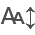

In [9]:
import itables

itables.init_notebook_mode()

In [10]:
itables.show(pd.DataFrame(ranked_wins))

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


## Win and Appearance Share by Group Type and Gender (2023-2025)

In [11]:
%%sql group_gender << WITH joined_placements AS (
  SELECT 
    a.*,
    m.Group_Solo,
    m."Member Gender",
    m."Debut Date"
  FROM all_awards a
  JOIN artist_metadata m ON a.artist = m.artist
),
year_totals AS (
  SELECT 
    STRFTIME('%Y', date) AS year,
    COUNT(*) AS total_appearances_year,
    SUM(CASE WHEN placement = 1 THEN 1 ELSE 0 END) AS total_wins_year
  FROM joined_placements
  GROUP BY year
),
aggregated_group_gender AS (
  SELECT 
    STRFTIME('%Y', date) AS year,
    Group_Solo AS group_or_solo,
    "Member Gender" AS member_gender,
    COUNT(*) AS total_appearances,
    SUM(CASE WHEN placement = 1 THEN 1 ELSE 0 END) AS total_wins
  FROM joined_placements
  GROUP BY year, group_or_solo, member_gender
),
final AS (
	SELECT
		agg.*,
		yt.total_appearances_year,
		yt.total_wins_year,
		ROUND(CAST(agg.total_appearances AS FLOAT) / yt.total_appearances_year, 3) AS appearance_share,
		ROUND(CAST(agg.total_wins AS FLOAT) / yt.total_wins_year, 3) AS wins_share
	FROM aggregated_group_gender agg
	JOIN year_totals yt ON agg.year = yt.year
)

SELECT 
	year,
  group_or_solo,
  member_gender,
  total_appearances,
  total_wins,
  appearance_share,
  wins_share
FROM final
ORDER BY year, group_or_solo, member_gender

 * sqlite:///../data/sql/clean.db
Done.
Returning data to local variable group_gender


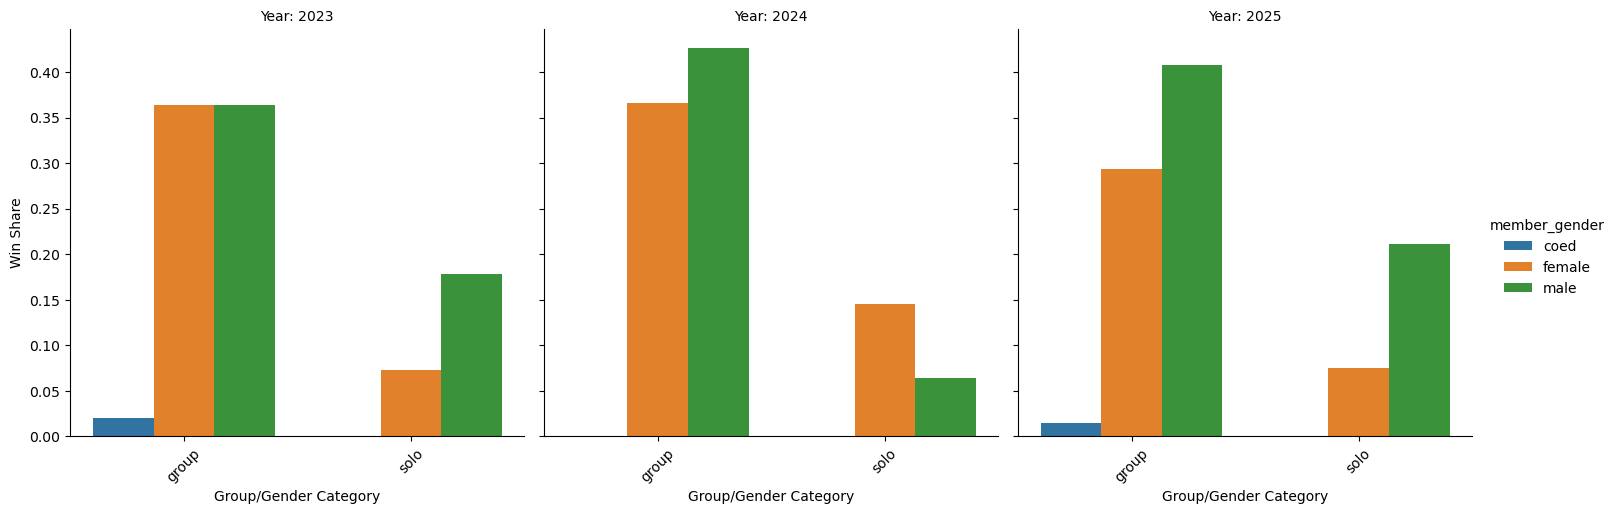

In [12]:
g = sns.catplot(data=group_gender.DataFrame(), x='group_or_solo', col='year', y='wins_share', hue='member_gender', kind='bar')
g.set_xticklabels(rotation=45)
g.set_titles("Year: {col_name}")
g.set_axis_labels("Group/Gender Category", "Win Share")

plt.show()

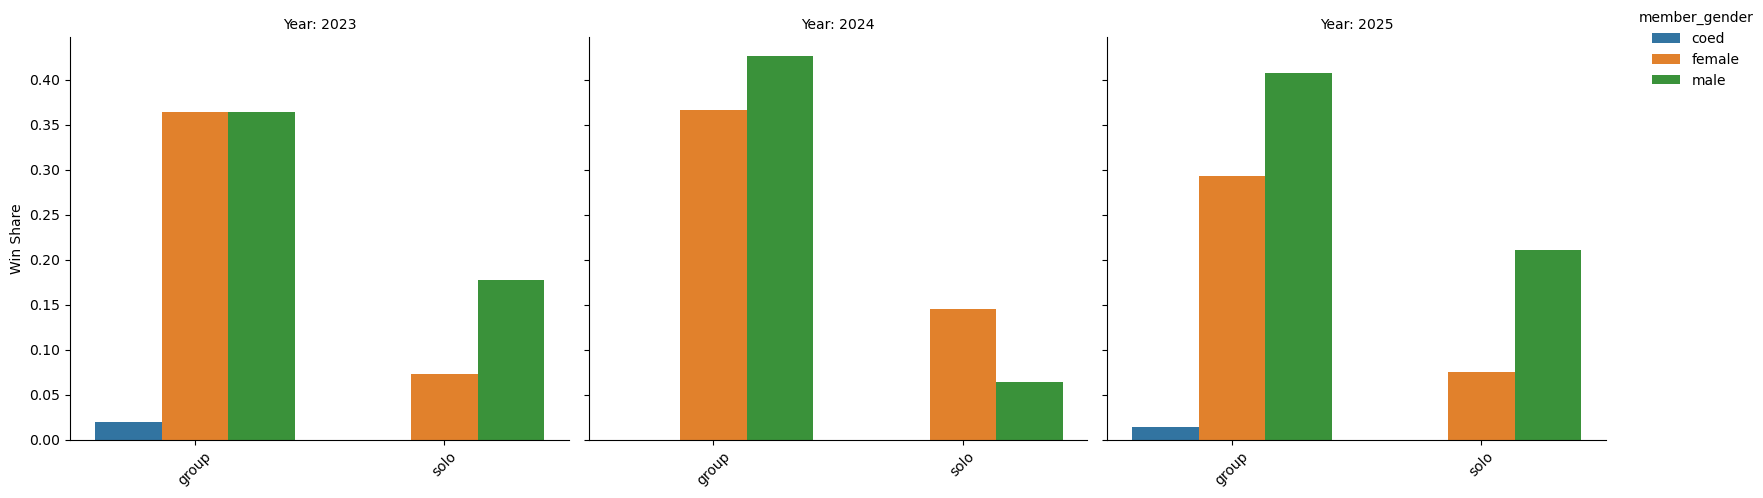

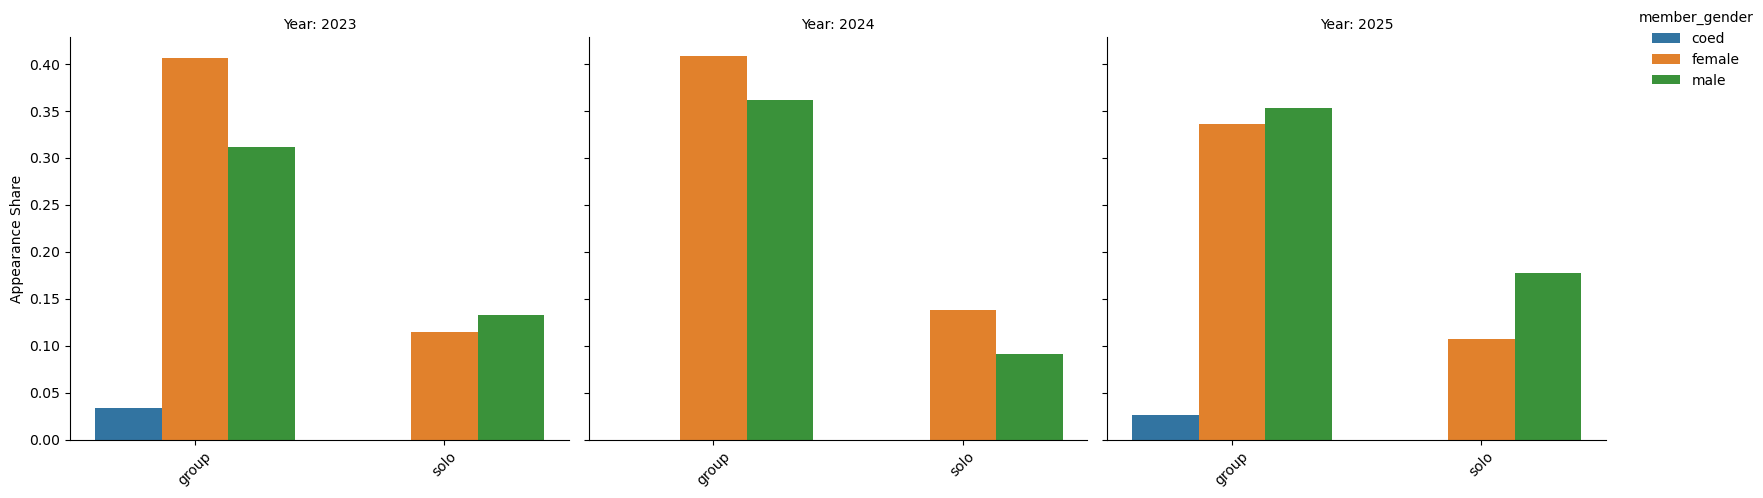

In [13]:
# Win share plot
g1 = sns.catplot(
    data=group_gender.DataFrame(), x='group_or_solo', col='year',
    y='wins_share', hue='member_gender', kind='bar'
)
g1.set_xticklabels(rotation=45)
g1.set_titles("Year: {col_name}")
g1.set_axis_labels("", "Win Share")
g1._legend.set_bbox_to_anchor((1,1))
g1._legend.set_loc("upper left")
plt.tight_layout()
plt.show()

# Appearance share plot
g2 = sns.catplot(
    data=group_gender.DataFrame(), x='group_or_solo', col='year',
    y='appearance_share', hue='member_gender', kind='bar'
)
g2.set_xticklabels(rotation=45)
g2.set_titles("Year: {col_name}")
g2.set_axis_labels("", "Appearance Share")
g2._legend.set_bbox_to_anchor((1,1))
g2._legend.set_loc("upper left")
plt.tight_layout()
plt.show()


## Debuts from 2023-2025

### Time to first win

In [14]:
%%sql 
WITH debut_range AS (
	SELECT * 
	FROM artist_metadata
	WHERE `Debut Date` BETWEEN '2023-01-01' AND '2025-12-31'
), first_wins AS (
	SELECT 
		artist,
		MIN(date) as first_win
	FROM all_awards
	WHERE placement = 1
	GROUP BY artist
)

SELECT 
	fw.*,
	dr.`Debut Date`,
	julianday(fw.first_win) - julianday(dr.`Debut Date`) as days_since_debut
FROM first_wins fw
JOIN debut_range dr ON 
fw.artist = dr.artist
ORDER BY days_since_debut DESC

 * sqlite:///../data/sql/clean.db
Done.


artist,first_win,Debut Date,days_since_debut
The Wind,2024-10-18 00:00:00,2023-05-15 00:00:00,522.0
n.Ssign,2025-01-10 00:00:00,2023-08-09 00:00:00,520.0
TEN,2025-04-01 00:00:00,2024-02-13 00:00:00,413.0
UNIS,2025-04-23 00:00:00,2024-03-27 00:00:00,392.0
KISS OF LIFE,2024-07-09 00:00:00,2023-07-05 00:00:00,370.0
PLAVE,2024-03-06 00:00:00,2023-03-12 00:00:00,360.0
QWER,2024-10-09 00:00:00,2023-10-18 00:00:00,357.0
MEOVV,2025-05-08 00:00:00,2024-09-06 00:00:00,244.0
BABYMONSTER,2024-05-02 00:00:00,2023-11-27 00:00:00,157.0
izna,2025-04-15 00:00:00,2024-11-25 00:00:00,141.0


### Debut Recency Trends

In [15]:
%%sql binned_debut <<
WITH joined_placements AS (
  SELECT 
    a.*,
    m.Group_Solo,
    m."Member Gender",
    m."Debut Date",
	strftime('%Y', a.date) - strftime('%Y', m."Debut Date") as years_since_debut
  FROM all_awards a
  JOIN artist_metadata m ON a.artist = m.artist
), binned_debut AS (
	SELECT 
		date,
		artist,
		song,
		total,
		`Debut Date`,
		years_since_debut,
		CASE 
			WHEN years_since_debut = 0 THEN '0'
			WHEN years_since_debut < 3 THEN '1-2'
			WHEN years_since_debut < 5 THEN '3-4'
			WHEN years_since_debut < 7 THEN '5-6'
			WHEN years_since_debut < 9 THEN '7-8'
			WHEN years_since_debut < 11 THEN '9-10'
			ELSE '11+'
		END as binned_years_since_debut
	FROM joined_placements
	WHERE placement = 1
)

SELECT 
	strftime('%Y', date) as year,
	binned_years_since_debut,
	COUNT(*) as win_count
FROM binned_debut
GROUP BY year, binned_years_since_debut

 * sqlite:///../data/sql/clean.db
Done.
Returning data to local variable binned_debut


In [16]:
binned_df = binned_debut.DataFrame()

debut_order = ['0', '1-2', '3-4', '5-6', '7-8', '9-10', '11+']
binned_df['binned_years_since_debut'] = pd.Categorical(binned_df['binned_years_since_debut'], categories=debut_order, ordered=True)

In [17]:
heatmap_data = binned_df.pivot(index='year', columns='binned_years_since_debut', values='win_count')

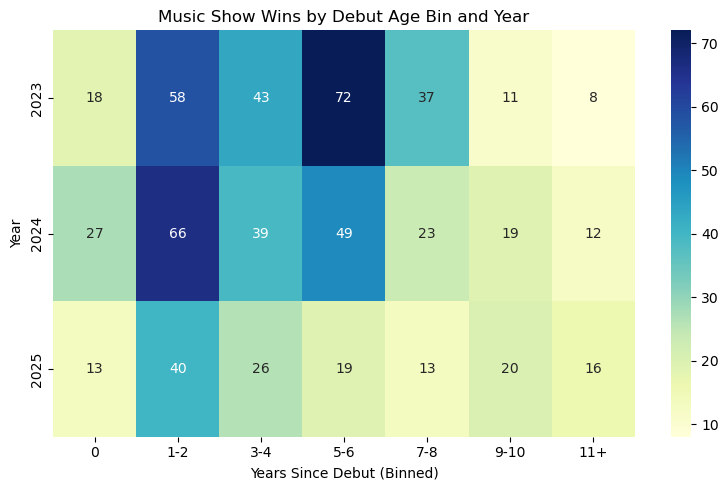

In [18]:
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='g')

plt.title('Music Show Wins by Debut Age Bin and Year')
plt.xlabel('Years Since Debut (Binned)')
plt.ylabel('Year')
plt.tight_layout()
plt.show()

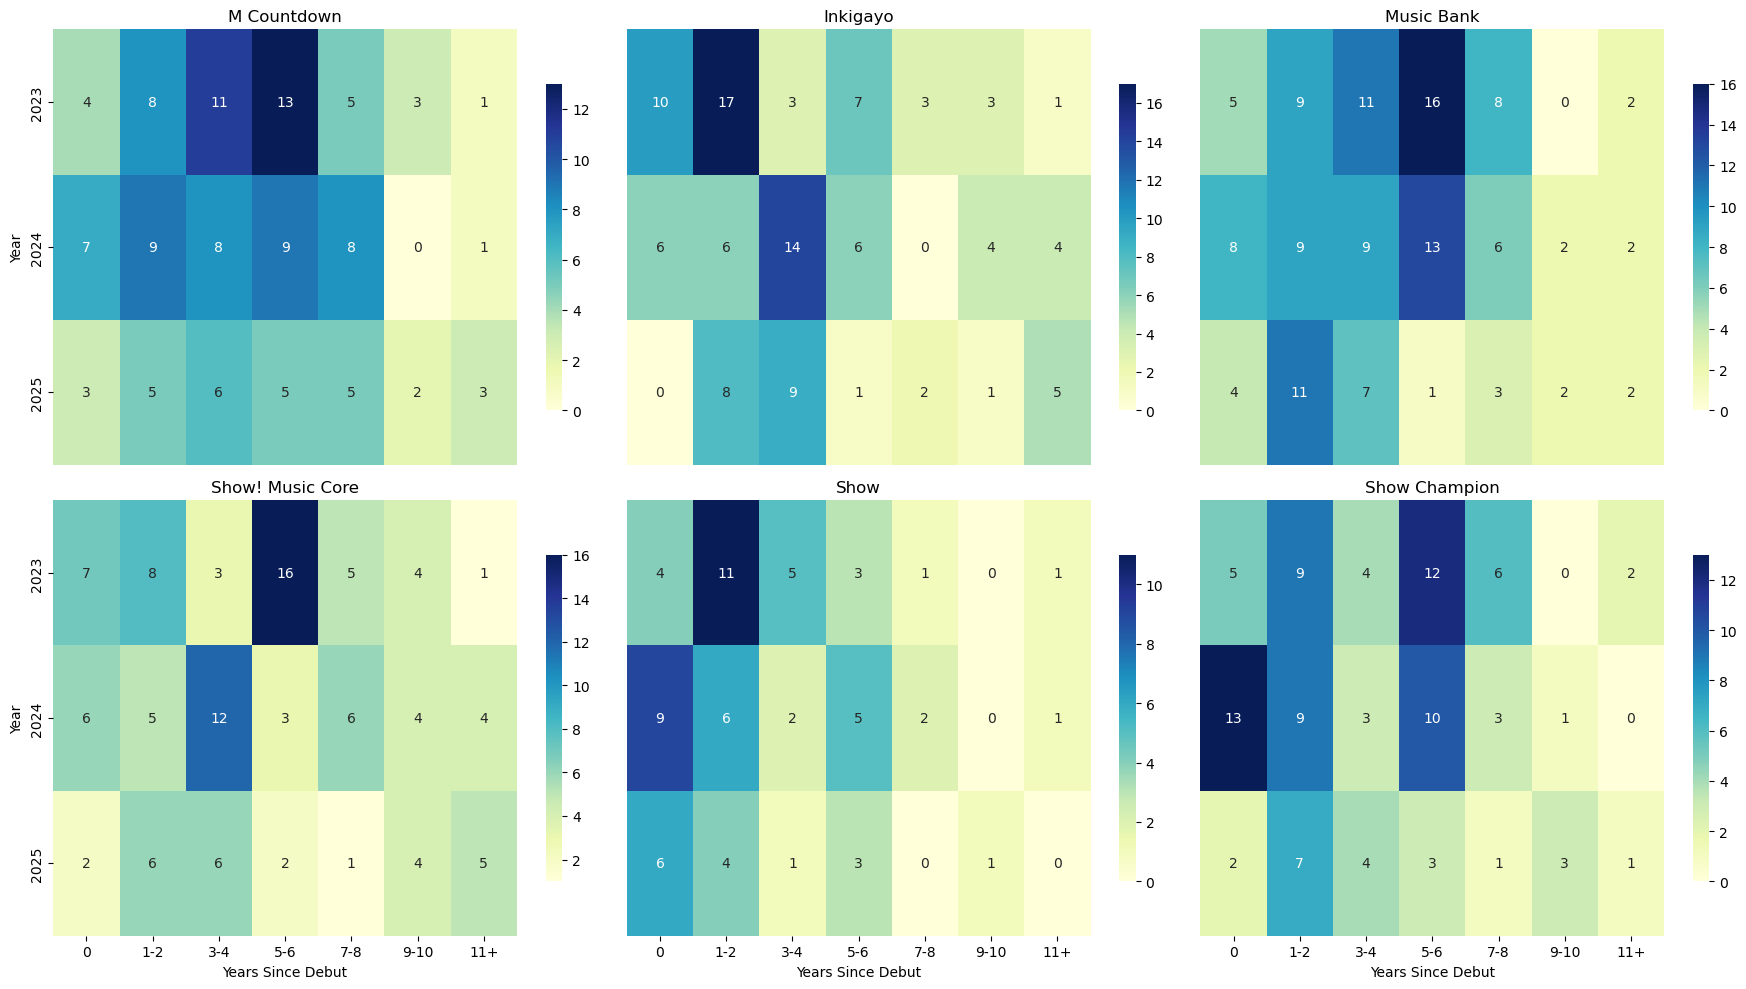

In [19]:
from plotting_sql_queries import plot_debut_bin_heatmap_grid, run_sql

show_names = ['M Countdown', 'Inkigayo', 'Music Bank', 'Show! Music Core', 'Show', 'Show Champion']
plot_debut_bin_heatmap_grid(run_sql, show_names, n_cols=3)

## Score Analysis

In [20]:
%%sql 
WITH top_2 AS ( 
	SELECT 
		f.show,
		f.date,
		f.artist as first_artist,
		f.song as first_song,
		s.artist as second_artist,
		s.song as second_song,
        f.total as first_total,
		s.total as second_total,
		f.total - s.total as point_differential
	FROM all_awards f
	JOIN all_awards s ON
		f.date=s.date AND s.placement=2 AND s.total<>0 
	WHERE f.placement=1 AND f.total<>0
)

SELECT * FROM top_2
ORDER BY point_differential DESC
LIMIT 4

 * sqlite:///../data/sql/clean.db
Done.


show,date,first_artist,first_song,second_artist,second_song,first_total,second_total,point_differential
Music Bank,2023-11-03 00:00:00,SEVENTEEN,God of Music,IVE,Baddie,16281,3478,12803
Music Bank,2025-04-25 00:00:00,NCT WISH,poppop,G-Dragon,TOO BAD (feat. Anderson Paak),14627,2459,12168
Music Bank,2025-06-13 00:00:00,ENHYPEN,Bad Desire (With or Without You),SEVENTEEN,THUNDER,15416,4942,10474
Music Bank,2024-01-26 00:00:00,NMIXX,DASH,JD1,who Am I,11952,2499,9453


### Summary Statistics on Point Differential and Winning Totals

In [21]:
%%sql
WITH top_2 AS ( 
	SELECT 
		f.show,
		f.date,
		strftime('%Y', f.date) as year,
		f.artist as first_artist,
		f.song as first_song,
		f.total as first_total,
		s.artist as second_artist,
		s.song as second_song,
		s.total as second_total,
		f.total - s.total as point_differential
	FROM all_awards f
	JOIN all_awards s ON
		f.date=s.date AND s.placement=2 AND s.total<>0 
	WHERE f.placement=1 AND f.total<>0
)

SELECT 
	show,
	year,
	MIN(point_differential) as smallest_point_diff,
	ROUND(AVG(point_differential), 2) as avg_point_diff,
	MAX(point_differential) as largest_point_diff,
	MIN(first_total) as lowest_winning_score,
	ROUND(AVG(first_total), 2) as avg_winning_score,
	MAX(first_total) as highest_winning_score
	
FROM top_2
GROUP BY show, year

 * sqlite:///../data/sql/clean.db
Done.


show,year,smallest_point_diff,avg_point_diff,largest_point_diff,lowest_winning_score,avg_winning_score,highest_winning_score
Inkigayo,2023,11,1203.77,3427,5675,7216.41,10586
Inkigayo,2024,63,1163.88,4403,4428,6716.27,8808
Inkigayo,2025,53,1477.92,5421,4434,5947.31,8906
M Countdown,2023,15,2103.49,5505,5737,8128.65,10669
M Countdown,2024,10,1903.89,5671,6031,7744.58,10293
M Countdown,2025,8,1733.37,5664,6636,7937.7,10567
Music Bank,2023,34,3775.0,12803,5154,9237.31,16281
Music Bank,2024,118,3258.53,9453,3389,8718.27,13101
Music Bank,2025,59,4212.83,12168,4087,9049.03,15416
Show,2023,23,3148.48,7025,6082,8162.08,9590


### Check if close wins are related to low scoring

In [22]:
%%sql
WITH top_2 AS ( 
	SELECT 
		f.show,
		f.date,
		strftime('%Y', f.date) as year,
		f.artist as first_artist,
		f.song as first_song,
		f.total as first_total,
		s.artist as second_artist,
		s.song as second_song,
		s.total as second_total,
		f.total - s.total as point_differential
	FROM all_awards f
	JOIN all_awards s ON
		f.date=s.date AND s.placement=2 AND s.total<>0 
	WHERE f.placement=1 AND f.total<>0
), min_diffs AS (
	SELECT 
		*,
		ROW_NUMBER() OVER (PARTITION BY show, year ORDER BY point_differential ASC) as rnk
	FROM top_2
), point_summary AS (
	SELECT 
	show,
	year,
	MIN(point_differential) as smallest_point_diff,
	ROUND(AVG(point_differential), 2) as avg_point_diff,
	MAX(point_differential) as largest_point_diff,
	MIN(first_total) as lowest_winning_score,
	ROUND(AVG(first_total), 2) as avg_winning_score,
	MAX(first_total) as highest_winning_score
	
	FROM top_2
	GROUP BY show, year
)

SELECT 
	md.show,
	md.year,
	md.first_total,
	md.point_differential,
	md.first_artist || ' - ' || md.first_song as first_place,
	md.second_artist || ' - ' || md.second_song as second_place
FROM min_diffs md
JOIN point_summary ps 
	ON md.show = ps.show AND md.year = ps.year
WHERE rnk=1 --AND md.first_total = ps.lowest_winning_score

 * sqlite:///../data/sql/clean.db
Done.


show,year,first_total,point_differential,first_place,second_place
Inkigayo,2023,6278,11,AKMU - Love Lee,JENNIE - You & Me
Inkigayo,2024,5739,63,ZEROBASEONE - GOOD SO BAD,NewJeans - How Sweet
Inkigayo,2025,4434,53,WOODZ - Drowning,SEVENTEEN - THUNDER
M Countdown,2023,6720,15,STRAY KIDS - S-Class,i-dle - Queencard
M Countdown,2024,6118,10,QWER - My Name Is Malgeum,YEONJUN - GGUM
M Countdown,2025,6687,8,G-Dragon - TOO BAD (feat. Anderson Paak),ZEROBASEONE - BLUE
Music Bank,2023,6587,34,V - Slow Dancing,Cravity - Ready Or Not
Music Bank,2024,4492,118,LE SSERAFIM - EASY,NCT WISH - WISH
Music Bank,2025,6903,59,fromis_9 - LIKE YOU BETTER,aespa - Dirty Work
Show,2023,7173,23,Jo Yu-ri - TAXI,Kwon Eun-bi - The Flash


**Mention how we can see some interesting h2h matchups which segweys into our next section: Matchups**

Queries we can try:
- time to first win: *must ensure we're looking at groups that debuted within the time period*
    - can explore both debut year dominance (total wins per year of win) to see what debut years dominate wins AND average time between debut and first win
- score analysis: look into win scores based on artist type or gender (could be bar graph or a line graph to demonstrate continuous time)
- debut recency win trends: bin artists by debut year vs. total wins
    - *Should be calculated relative to the year of interest; preservers temporal consistency*
- average point differential of winners or seasonal/yearly trends in point differentials
- closest matchups
- frequent rivals, matchup diversity
- underdogs
    - All analyses are based on show wins and placements recorded from 2023 to 2025. Artists who debuted before 2023 may have additional career wins or performances not captured within this dataset, which may affect how underdog or dominant performances are interpreted.

Possible grouping
- Score analysis **Completed**
    - average win scores, point differtials
- Debuts from 2023-2025 **COMPLETED**
    - time to first win, debut recency win trends 
- Matchups
    - closest point differential, frequent and diverse matchups, underdogs
    - *Should declare the limitation of having data from 2023-2025*
    - can look into tenure matchups

## Matchups

### Artist Matchups

In [27]:
%%sql artist_matchups <<
WITH matchups AS (
    SELECT 
        a.show,
        STRFTIME('%Y', a.date) AS year,
        a.date,
        a.artist AS artist_a,
        b.artist AS artist_b,
        CASE 
            WHEN a.placement = 1 THEN a.artist
            WHEN b.placement = 1 THEN b.artist
        END AS winner
    FROM all_awards a
    JOIN all_awards b 
      ON a.show = b.show 
     AND a.date = b.date
     AND a.artist < b.artist
    WHERE 
        a.placement IN (1, 2) 
        AND b.placement IN (1, 2)
),
matchup_totals AS (
    SELECT 
        artist_a,
        artist_b,
        COUNT(*) AS total_matchups,
        SUM(CASE WHEN winner = artist_a THEN 1 ELSE 0 END) AS artist_a_wins,
        SUM(CASE WHEN winner = artist_b THEN 1 ELSE 0 END) AS artist_b_wins
    FROM matchups
    GROUP BY artist_a, artist_b
)

SELECT 
	CASE 
        WHEN artist_a_wins >= artist_b_wins THEN artist_a
        ELSE artist_b
    END AS artist_a,
    CASE 
        WHEN artist_a_wins >= artist_b_wins THEN artist_b
        ELSE artist_a
    END AS artist_b,
    CASE 
        WHEN artist_a_wins >= artist_b_wins THEN artist_a_wins
        ELSE artist_b_wins
    END AS artist_a_wins,
    CASE 
        WHEN artist_a_wins >= artist_b_wins THEN artist_b_wins
        ELSE artist_a_wins
    END AS artist_b_wins,
    total_matchups,
    CASE 
        WHEN artist_a_wins >= artist_b_wins THEN ROUND(CAST(artist_a_wins as FLOAT) / (artist_a_wins + artist_b_wins), 2)
        ELSE ROUND(CAST(artist_b_wins as FLOAT) / (artist_a_wins + artist_b_wins), 2)
    END AS win_ratio
FROM matchup_totals
ORDER BY total_matchups DESC

 * sqlite:///../data/sql/clean.db
Done.
Returning data to local variable artist_matchups


In [ ]:
artist_matchups = artist_matchups.DataFrame()
artist_matchups.iloc[:10]

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


In [34]:
artist_matchups.loc[(artist_matchups.win_ratio > 0.35) & (artist_matchups.win_ratio <= 0.65), :]

Loading ITables v2.4.4 from the init_notebook_mode cell... (need help?)


### Artist Type Matchups

In [24]:
%%sql composition << 
WITH matchups AS (
    SELECT 
        a.show,
        STRFTIME('%Y', a.date) AS year,
        a.date,
        a.artist AS artist_a,
        b.artist AS artist_b,
        CASE 
            WHEN a.placement = 1 THEN a.artist
            WHEN b.placement = 1 THEN b.artist
        END AS winner
    FROM all_awards a
    JOIN all_awards b 
      ON a.show = b.show 
     AND a.date = b.date
     AND a.artist < b.artist
    WHERE 
        a.placement IN (1, 2) 
        AND b.placement IN (1, 2)
),
matchup_totals AS (
    SELECT 
        artist_a,
        artist_b,
        COUNT(*) AS total_matchups,
        SUM(CASE WHEN winner = artist_a THEN 1 ELSE 0 END) AS artist_a_wins,
        SUM(CASE WHEN winner = artist_b THEN 1 ELSE 0 END) AS artist_b_wins
    FROM matchups
    GROUP BY artist_a, artist_b
),
matchup_with_meta AS (
    SELECT 
        am1.Group_Solo || ' - ' || am1.`Member Gender` AS group_comp_a,
        am2.Group_Solo || ' - ' || am2.`Member Gender` AS group_comp_b,
        artist_a_wins,
        artist_b_wins,
        total_matchups
    FROM matchup_totals m
    JOIN artist_metadata am1 ON am1.artist = m.artist_a
    JOIN artist_metadata am2 ON am2.artist = m.artist_b
),
canonical_pairs AS (
    SELECT
        CASE 
            WHEN group_comp_a < group_comp_b THEN group_comp_a 
            ELSE group_comp_b 
        END AS group1,
        CASE 
            WHEN group_comp_a < group_comp_b THEN group_comp_b 
            ELSE group_comp_a 
        END AS group2,
        CASE 
            WHEN group_comp_a < group_comp_b THEN artist_a_wins 
            ELSE artist_b_wins 
        END AS wins_group1,
        CASE 
            WHEN group_comp_a < group_comp_b THEN artist_b_wins 
            ELSE artist_a_wins 
        END AS wins_group2,
        total_matchups
    FROM matchup_with_meta
),
aggregated_pairs AS (
    SELECT 
        group1,
        group2,
        SUM(wins_group1) AS group1_wins,
        SUM(wins_group2) AS group2_wins,
        SUM(total_matchups) AS total_matchups
    FROM canonical_pairs
    GROUP BY group1, group2
),
symmetric_results AS (
    -- Original direction
    SELECT 
        group1 AS group_comp_a,
        group2 AS group_comp_b,
        group1_wins AS group_comp_a_wins,
        group2_wins AS group_comp_b_wins,
        total_matchups
    FROM aggregated_pairs
    
    UNION ALL
    
    -- Reverse direction (only for different group types to avoid duplicating same-type matchups)
    SELECT 
        group2 AS group_comp_a,
        group1 AS group_comp_b,
        group2_wins AS group_comp_a_wins,
        group1_wins AS group_comp_b_wins,
        total_matchups
    FROM aggregated_pairs
    WHERE group1 != group2
)
SELECT 
    group_comp_a,
    group_comp_b,
    group_comp_a_wins,
    group_comp_b_wins,
    total_matchups
FROM symmetric_results
ORDER BY total_matchups DESC;

 * sqlite:///../data/sql/clean.db
Done.
Returning data to local variable composition


In [25]:
composition

group_comp_a,group_comp_b,group_comp_a_wins,group_comp_b_wins,total_matchups
group - female,group - male,80,115,195
group - male,group - female,115,80,195
group - female,group - female,47,22,69
group - female,solo - male,26,40,66
group - male,group - male,24,42,66
solo - male,group - female,40,26,66
group - female,solo - female,28,35,63
solo - female,group - female,35,28,63
group - male,solo - male,35,26,61
solo - male,group - male,26,35,61


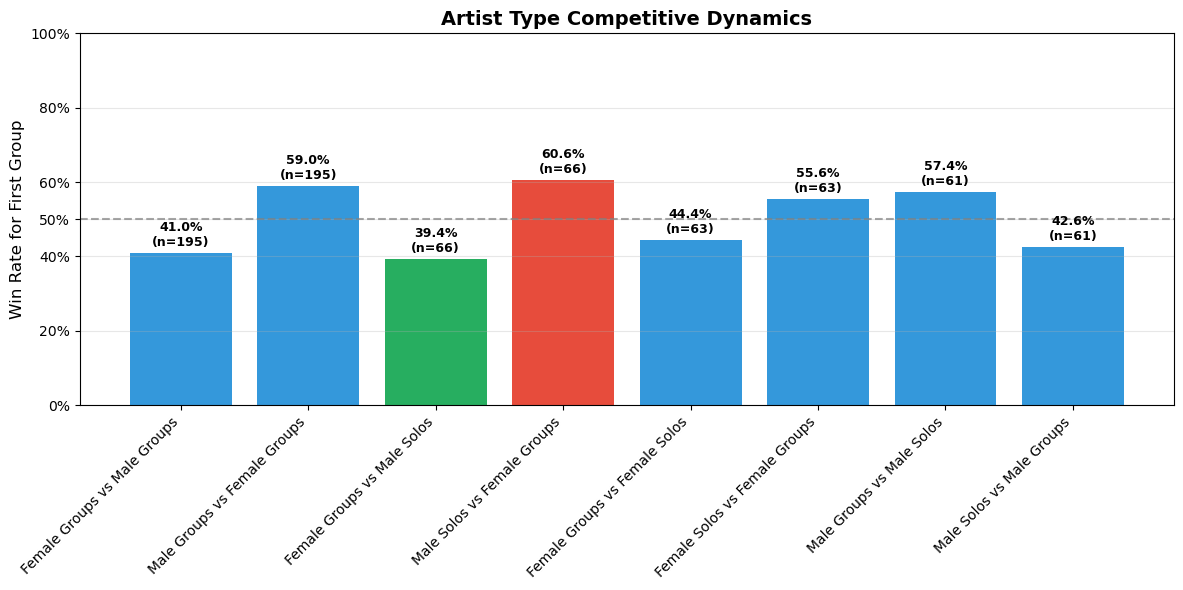

In [26]:
from plotting_sql_queries import plot_gender_matchup_chart
# plot_matchup_bar_chart(composition.DataFrame())
plot_gender_matchup_chart(composition.DataFrame())

### Years since Debut Matchups